# Imports and define expectation func

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [4]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils import plot_distributions, plot_history
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG
torch.set_default_dtype(torch.float64)

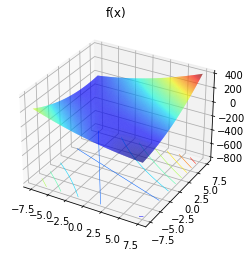

In [5]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Lumpy High Dimension Flow Target Distribution

In [6]:
torch.manual_seed(0) 
dim = 3
n_samples_estimation = int(1e6)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3).to("cuda")
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
#print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # print twice to make sure estimates are resonably close

tensor(23.6065, device='cuda:0')


In [7]:
epochs = int(1e4)
batch_size = int(1e3)

# DReG, alpha=2

In [8]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=30, scaling_factor=2.0, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-4, 
                                  weight_decay=1e-6)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

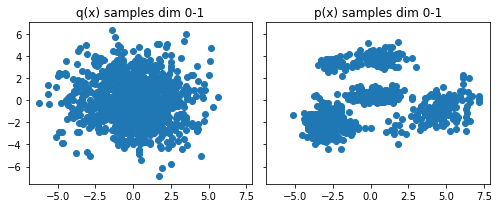

In [9]:
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

loss: 0.5021710783417592, mean log p_x -15.005891528596676:   0%|          | 0/10000 [00:00<?, ?it/s]

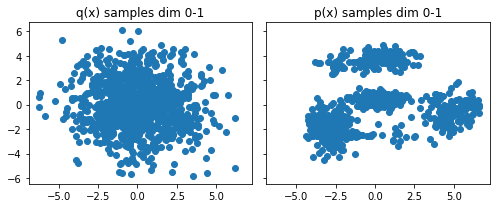

loss: -0.8697567346339256, mean log p_x -13.583454740959551:  10%|█         | 1000/10000 [05:45<47:42,  3.14it/s] 

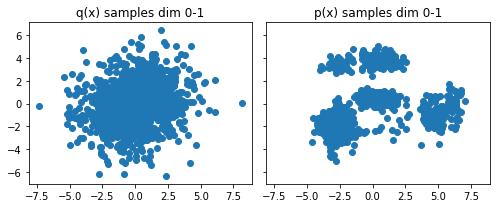

loss: 7.859749352827583, mean log p_x -13.074077200281259:  20%|██        | 2000/10000 [11:08<42:32,  3.13it/s]    

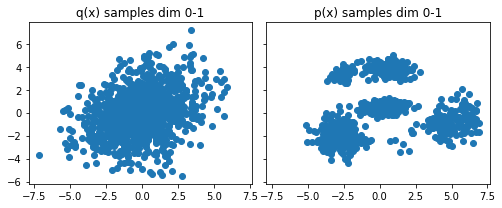

loss: 4.619564630236751, mean log p_x -12.326720719564895:  30%|███       | 3000/10000 [16:00<34:12,  3.41it/s]  

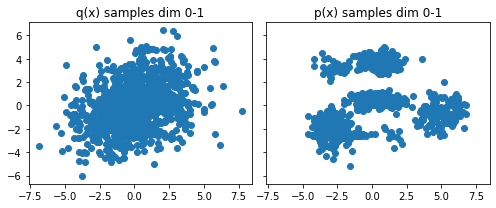

loss: -0.47094651128394277, mean log p_x -12.432499027210532:  40%|████      | 4000/10000 [21:39<40:05,  2.49it/s] 

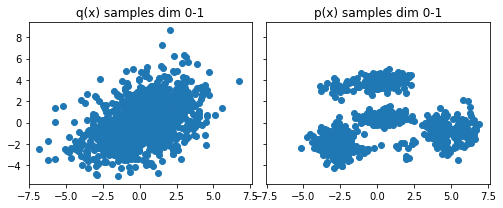

loss: 0.18896630070067189, mean log p_x -11.995433938796344:  50%|█████     | 5000/10000 [28:50<37:19,  2.23it/s]   

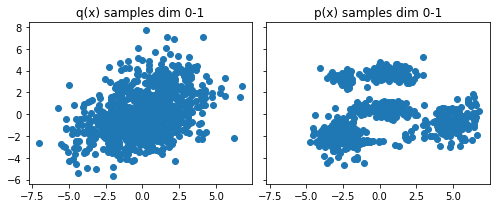

loss: -0.230167634131252, mean log p_x -12.16259459945732:  60%|██████    | 6000/10000 [35:43<31:23,  2.12it/s]    

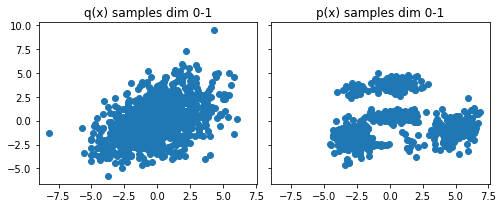

loss: -0.5639783141591923, mean log p_x -11.817783655495857:  70%|███████   | 7000/10000 [42:56<19:41,  2.54it/s]

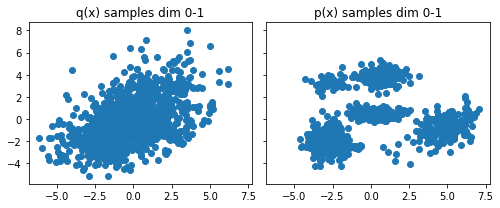

loss: -2.5219314869078984, mean log p_x -12.014801369567689:  80%|████████  | 8000/10000 [50:01<13:54,  2.40it/s]

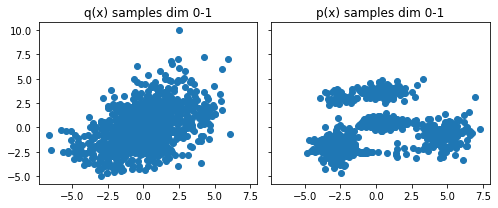

loss: -2.253052461131277, mean log p_x -12.601906195772695:  90%|█████████ | 9000/10000 [57:02<06:52,  2.42it/s] 

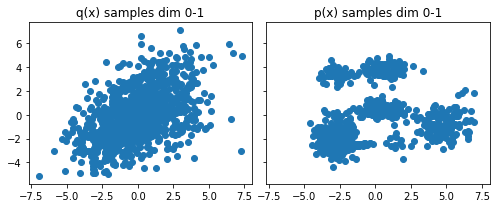

loss: -2.1053731960027346, mean log p_x -12.851387486807857: 100%|██████████| 10000/10000 [1:01:56<00:00,  2.69it/s]


In [10]:
history = tester.train(epochs, batch_size=batch_size, clip_grad_norm=True, max_grad_norm=1, 
                       intermediate_plots=True)

In [11]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 23.606452440031017 
estimate before training is 23.318672619373295 
estimate after training is 20.358205960944648 
effective sample size before is 0.0008457191225065063
effective sample size after train is 0.04935990755404816
variance in weights is 1.925937648983119e-11


In [12]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 23.606452440031017 
estimate before training is 23.318672619373295 
estimate after training is 20.358205960944648 
effective sample size before is 0.0008457191225065063
effective sample size after train is 0.04935990755404816
variance in weights is 1.925937648983119e-11


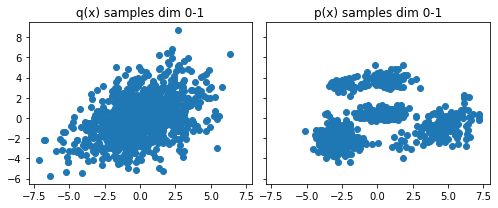

In [13]:
samples_fig_after = plot_samples(tester)

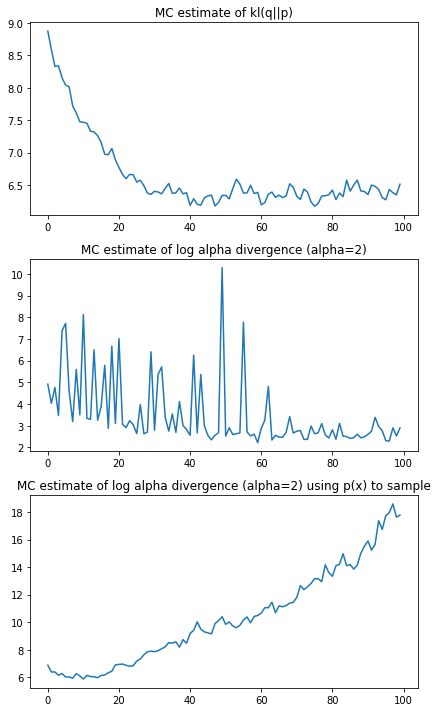

In [14]:
plot_divergences(history)

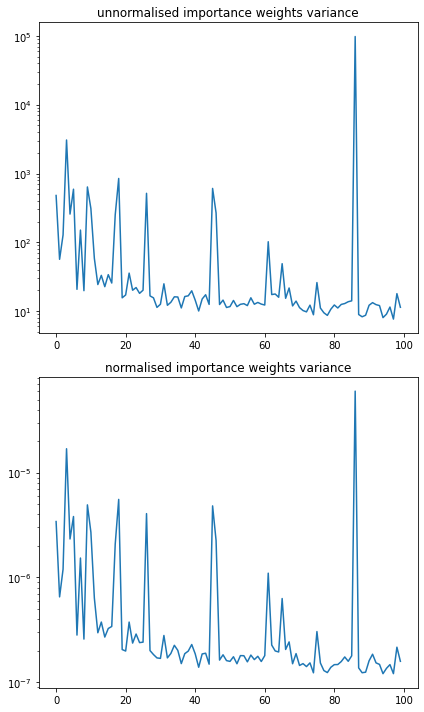

In [15]:
plot_sampling_info(history)

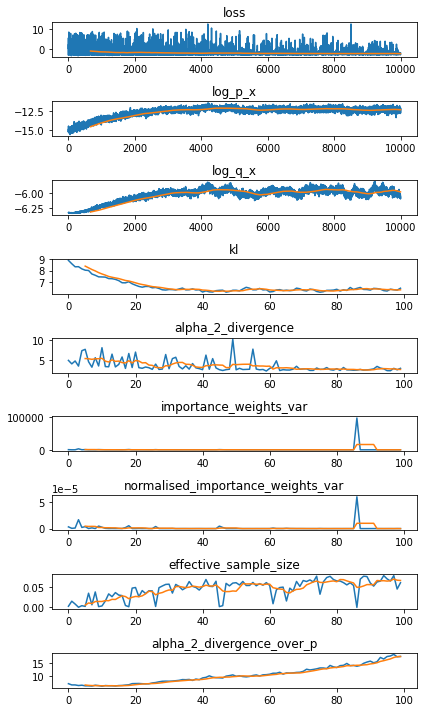

In [16]:
plot_history(history)

# KL

In [ ]:
torch.manual_seed(1)
learnt_sampler_kl = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester_kl = LearntDistributionManager(target, learnt_sampler_kl, VanillaImportanceSampling, loss_type="kl", lr=1e-3)
expectation_before_kl, info_before_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
samples_fig_before = plot_samples(tester_kl)

In [ ]:
history_kl = tester_kl.train(epochs, batch_size=batch_size,)

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester_kl)

In [ ]:
plot_divergences(history_kl)

In [ ]:
plot_sampling_info(history_kl)

In [ ]:
hist_plot = plot_history(history_kl)